In [1]:
#Upload kml file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,skew
from scipy import stats
from sklearn.neighbors import KDTree
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV, ElasticNetCV, LassoCV,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from pykml import parser
import warnings
warnings.filterwarnings("ignore")

with open('../Resources/glims_polygons.kml', 'r', encoding="utf-8") as f:
   root = parser.parse(f).getroot()
#Put kml to dataframe  
places = []
for place in root.Document.Folder.Placemark:
    data = {item.get("name"): item.text for item in
            place.ExtendedData.SchemaData.SimpleData}
    coords = place.Polygon.outerBoundaryIs.LinearRing.coordinates.text.strip()
    data["Coordinates"] = coords
    places.append(data)
df = pd.DataFrame(places)
# print(df)

In [2]:
cleaned_df = df[['line_type','anlys_id','area','glac_id','anlys_time',
               'src_date','db_area','min_elev','mean_elev','max_elev',
               'primeclass','Coordinates','rec_status','release_dt','gone_date',
               'glac_name','glac_stat','proc_desc','geog_area','conn_lvl',
               'surge_type','term_type','gtng_o1reg','gtng_o2reg','rgi_gl_typ']]
cleaned_df.head()

# Counting initial number of rows to make sure we don't somehow lose any.
row_count = cleaned_df.shape[0]
print(f"Number of rows: {row_count}")

Number of rows: 69572


In [3]:
# making a df copy
cleaned_df_3 = cleaned_df
#making exists to 1 and gone to 0 for glacier status
cleaned_df_3['glac_stat'] = cleaned_df_3['glac_stat'].replace({'gone': '0', 'exists': '1'})

In [4]:
# Changed the times which were strings to times that are datetime objects. Took away the hour and rounded off to a day, which
# wasn't intentional, but we don't need hourly resolution for a measurement of an object that changes very slowly
# and that we are only seeing measurements for a few times per year at most

cleaned_working_df_1 = cleaned_df_3.copy()


cleaned_working_df_1[['src_date', 'anlys_time', 'release_dt']] = cleaned_working_df_1[['src_date', 'anlys_time', 'release_dt']].apply(pd.to_datetime)


# Converted the times to unix. Unix times before 1/1/1970 are negative numbers, descending from 0 below 1/1/1970, so they'll still work and be
# convertible and comparable.
# Of note, minimum recording is 12/13/1901, so if there were dates before that, this would not be feasible.

cleaned_working_df_1['src_date'] = cleaned_working_df_1['src_date'].apply(lambda x: int(x.timestamp()))
cleaned_working_df_1['anlys_time'] = cleaned_working_df_1['anlys_time'].apply(lambda x: int(x.timestamp()))
cleaned_working_df_1['release_dt'] = cleaned_working_df_1['release_dt'].apply(lambda x: int(x.timestamp()))

# format for gone_date. the object wasn't recognized as a time like the other was, so I explicitly defined the format.
gone_date_raw_format = '%Y-%m-%d'

# Converting gone_date to datetime.
cleaned_working_df_1['gone_date'] = pd.to_datetime(cleaned_working_df_1['gone_date'], format=gone_date_raw_format, errors='coerce')

# Converting gone_date to unix. If the glacier still exists, it's a NaT, so replacing it with e for exists.
nat_replace_if_exists = 'e'
cleaned_working_df_1['gone_date'] = cleaned_working_df_1['gone_date'].apply(
    lambda x: int(x.timestamp()) if pd.notna(x) else nat_replace_if_exists
)

cleaned_df_3 = cleaned_working_df_1.copy()

In [5]:
# Copying data frame

cleaned_df_4 = cleaned_df_3.copy()

# Converting columns to float. errors='coerce' won't effect 0 values, but any non-number will be converted to nan. Will print between this conversion and
# the formatting just to make sure.

cleaned_df_4['area'] = pd.to_numeric(cleaned_df_4['area'], errors='coerce')
cleaned_df_4['db_area'] = pd.to_numeric(cleaned_df_4['db_area'], errors='coerce')

nat_replace = 'x'

# nan_rows # no nan rows for either area or db_area, so we're good, per the below check.
# nan_rows = cleaned_df_4[cleaned_df_4['db_area'].isna()]

# converting to float with the trailing digits removed. The number is the number of the significant digits we round to.

for column in ['area', 'db_area']:
    cleaned_df_4[column] = cleaned_df_4[column].apply(lambda x: '{:.15g}'.format(x) if pd.notnull(x) else nat_replace)



In [6]:
# Drop the analysis ID column for cleaned_df_5. We LIKELY don't need it.

cleaned_df_5 = cleaned_df_4.drop(columns=['anlys_id'])

In [7]:
# We still have the same number of rows. Check the cell above that lists row count for cleaned_df
row_count = cleaned_df_5.shape[0]
print(f"Number of rows: {row_count}")

Number of rows: 69572


In [8]:
cleaned_df_6 = cleaned_df_5.copy()
#Put in first coordinate column to split the coordinates latitude and longitude
cleaned_df_6['first_coordinate'] = cleaned_df_6['Coordinates'].apply(lambda x: x.split(',0')[0])

cleaned_df_6

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,glac_stat,proc_desc,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-136.675873,58.385483"
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,5,None,"-140.10202,59.96069"
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-137.260638,58.805875"
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-136.662581,58.464275"
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-136.652551,58.490007"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,5,None,"-105.690397,40.449164"
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,4,None,"-121.193295,48.16877"
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,5,None,"-113.72218,45.31765"
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,4,None,"-121.777004,44.173283"


In [9]:
#Drop Main coordinates column
cleaned_df_6.drop(columns=['Coordinates'], inplace=True)

cleaned_df_6

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,glac_stat,proc_desc,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-136.675873,58.385483"
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,5,None,"-140.10202,59.96069"
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-137.260638,58.805875"
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-136.662581,58.464275"
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,1,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,"-136.652551,58.490007"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,5,None,"-105.690397,40.449164"
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,4,None,"-121.193295,48.16877"
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,5,None,"-113.72218,45.31765"
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,1,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,4,None,"-121.777004,44.173283"


In [10]:
cleaned_df_7 = cleaned_df_6.copy()
#Put in column separate latitude and longitude
cleaned_df_7[['lng', 'lat']] = cleaned_df_7['first_coordinate'].str.split(',', expand=True)
#Convert to numeric to allow computations on clumns
cleaned_df_7['lat'] = pd.to_numeric(cleaned_df_7['lat'])
cleaned_df_7['lng'] = pd.to_numeric(cleaned_df_7['lng'])

cleaned_df_7

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Various (NSIDC),0,0,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,Various (NSIDC),0,0,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,Various (NSIDC),0,0,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Various (NSIDC),0,0,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,Various (NSIDC),0,0,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,Conterminous USA,0,0,9,2,5,None,"-105.690397,40.449164",-105.690397,40.449164
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,Conterminous USA,0,0,9,2,4,None,"-121.193295,48.16877",-121.193295,48.168770
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,Conterminous USA,0,0,9,2,5,None,"-113.72218,45.31765",-113.722180,45.317650
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,Conterminous USA,0,0,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283


In [11]:
#cleaned_df_7.drop(columns=['first_coordinate'], inplace=True)

avg_lat_lng_df = cleaned_df_7.groupby('glac_name')[['lat', 'lng']].mean().reset_index()

avg_lat_lng_df

#avg_lat_lng_df.to_csv('../Resources/glacier_avg_lat_lng.csv', index=False)

#cleaned_df_7.to_csv('../Resources/cleaned_df_7.csv', index=False)

,glac_name,lat,lng
0,1,61.843030,-149.484166
1,10,62.725465,-151.542192
2,100,62.927452,-150.794716
3,1000,63.093233,-150.569552
4,1001,63.093039,-150.545448
...,...,...,...
1650,Yalik Glacier,59.538355,-150.794766
1651,Yanert Glacier,63.604379,-147.616594
1652,Yawning Glacier,48.448965,-121.034797
1653,Yentna Glacier,62.930110,-151.443491


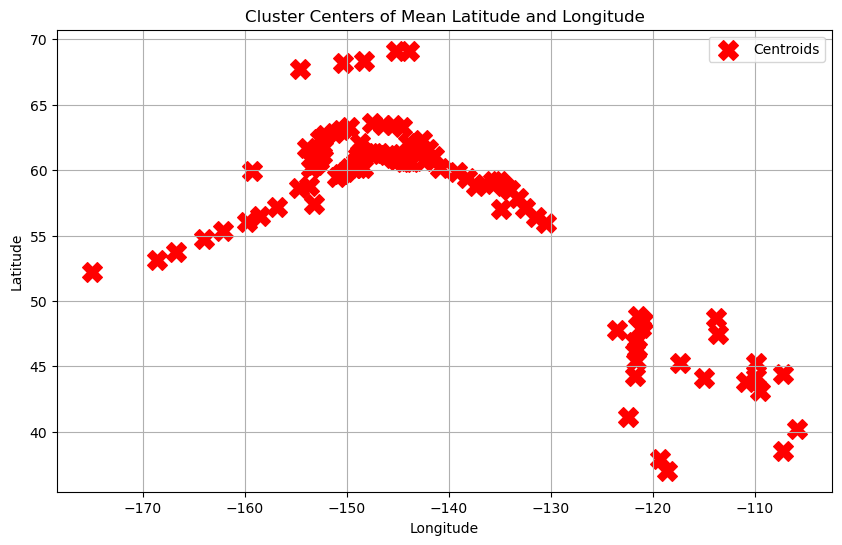

In [12]:
#Create regions for latitude and longitude for better model performance according to 
#https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c
# Define the number of clusters
num_clusters = 100

# Initialize KMeans with the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the KMeans model
cleaned_df_7[['lat', 'lng']] = cleaned_df_7[['lat', 'lng']].astype(float)
cleaned_df_7['cluster'] = kmeans.fit_predict(cleaned_df_7[['lat', 'lng']])

# Calculate the average coordinates for each cluster
cluster_means = cleaned_df_7.groupby('cluster')[['lat', 'lng']].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot cluster centers
plt.scatter(cluster_means['lng'], cluster_means['lat'], c='red', s=200, marker='X', label='Centroids')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers of Mean Latitude and Longitude')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

cluster_means.to_csv('../Resources/100_cluster_means.csv')

In [13]:
# Convert cluster means to DataFrame
cluster_means_df = pd.DataFrame(cluster_means, columns=['lat', 'lng'])

# Create a column 'cluster_id' for index purposes starting at 1
cluster_means_df['cluster_id'] = range(1, len(cluster_means_df) + 1)

# Set 'cluster_id' as the index
cluster_means_df.set_index('cluster_id', inplace=True)

kdtree = KDTree(cluster_means_df[['lat', 'lng']].values)

In [14]:
data_coords = cleaned_df_7[['lat', 'lng']].values
#Set variable for query, then place results of query to variable
distances, indices = kdtree.query(data_coords)
#Flatten indicies to allow as use as variables in iloc
indices = indices.flatten()

In [15]:
#Use incides to iloc for closest cluster
cleaned_df_7['closest_cluster_lat'] = cluster_means_df['lat'].iloc[indices].values
cleaned_df_7['closest_cluster_lng'] = cluster_means_df['lng'].iloc[indices].values

cleaned_df_7

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744
1,debris_cov,0,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,...,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022
2,debris_cov,0,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,...,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258
3,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744
4,debris_cov,0,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,...,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,0.015946,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,...,9,2,5,None,"-105.690397,40.449164",-105.690397,40.449164,3,40.219607,-105.876157
69568,glac_bound,0.011637,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,...,9,2,4,None,"-121.193295,48.16877",-121.193295,48.168770,36,47.921442,-121.151517
69569,glac_bound,0.024188,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,...,9,2,5,None,"-113.72218,45.31765",-113.722180,45.317650,30,44.069954,-114.970348
69570,glac_bound,0.03978,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,...,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283,72,44.229202,-121.769272


In [16]:
#Check for area
rows_with_zero_area = cleaned_df_7[cleaned_df_7['area'] == 0]

rows_with_zero_area

,line_type,area,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng


In [17]:
# DROP area as it is sometimes not provided by researchers
rows_with_area = cleaned_df_7.drop(columns=['area'])
rows_with_area

,line_type,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,debris_cov,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,okay,...,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744
1,debris_cov,G219795E60080N,1186713213,995500800,297.56,0,0,0,5,okay,...,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022
2,debris_cov,G222829E58804N,1148929281,933465600,162.882,0,0,0,5,okay,...,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258
3,debris_cov,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,okay,...,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744
4,debris_cov,G223237E58554N,1148543303,933465600,495.176,0,0,0,4,okay,...,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,G254310E40448N,1676505600,1602720000,0.015945,0,0,0,7,okay,...,9,2,5,None,"-105.690397,40.449164",-105.690397,40.449164,3,40.219607,-105.876157
69568,glac_bound,G238806E48169N,1676505600,1441756800,0.011638,0,0,0,7,okay,...,9,2,4,None,"-121.193295,48.16877",-121.193295,48.168770,36,47.921442,-121.151517
69569,glac_bound,G246279E45318N,1676505600,1378684800,0.024188,0,0,0,7,okay,...,9,2,5,None,"-113.72218,45.31765",-113.722180,45.317650,30,44.069954,-114.970348
69570,glac_bound,G238224E44172N,1676505600,1537142400,0.03978,0,0,0,6,okay,...,9,2,4,None,"-121.777004,44.173283",-121.777004,44.173283,72,44.229202,-121.769272


In [18]:
#Add Temperature
temps_df = pd.read_csv('../Resources/Monthly_Avg_Temp_1990_2024.csv')
temps_df.head()


,Date,Value,Anomaly
0,199001,36.48,6.36
1,199002,36.59,4.62
2,199003,39.31,4.16
3,199004,42.61,3.49
4,199005,45.86,2.53


In [19]:
#Split
temps_df['formatted_date'] = temps_df['Date'].apply(lambda x: f"{str(x)[:4]}-{str(x)[4:]}")

temps_df['datetime'] = pd.to_datetime(temps_df['formatted_date'], format='%Y-%m')

temps_df.head(24)

,Date,Value,Anomaly,formatted_date,datetime
0,199001,36.48,6.36,1990-01,1990-01-01
1,199002,36.59,4.62,1990-02,1990-02-01
2,199003,39.31,4.16,1990-03,1990-03-01
3,199004,42.61,3.49,1990-04,1990-04-01
4,199005,45.86,2.53,1990-05,1990-05-01
5,199006,49.92,2.40,1990-06,1990-06-01
6,199007,53.25,2.00,1990-07,1990-07-01
7,199008,55.62,1.77,1990-08,1990-08-01
8,199009,56.92,1.85,1990-09,1990-09-01
9,199010,56.63,1.66,1990-10,1990-10-01


In [20]:
temps_df = temps_df.drop(columns=['Date', 'Anomaly', 'formatted_date'])
temps_df.head()

,Value,datetime
0,36.48,1990-01-01
1,36.59,1990-02-01
2,39.31,1990-03-01
3,42.61,1990-04-01
4,45.86,1990-05-01


In [21]:
rows_with_area.columns

Index(['line_type', 'glac_id', 'anlys_time', 'src_date', 'db_area', 'min_elev',
       'mean_elev', 'max_elev', 'primeclass', 'rec_status', 'release_dt',
       'gone_date', 'glac_name', 'glac_stat', 'proc_desc', 'geog_area',
       'conn_lvl', 'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg',
       'rgi_gl_typ', 'first_coordinate', 'lng', 'lat', 'cluster',
       'closest_cluster_lat', 'closest_cluster_lng'],
      dtype='object')

In [22]:
rows_with_area['anlys_time'] = pd.to_datetime(rows_with_area['anlys_time'],unit='s')
rows_with_area['src_date'] = pd.to_datetime(rows_with_area['src_date'],unit='s')
#rows_with_area['gone_date'] = pd.to_datetime(rows_with_area['gone_date'])


rows_with_area['anlys_time'] = rows_with_area['anlys_time'].dt.date
rows_with_area['src_date'] = rows_with_area['src_date'].dt.date

#rows_with_area['anlys_time'] = pd.to_datetime(rows_with_area['anlys_time'])
#rows_with_area['gone_date'] = rows_with_area['gone_date'].dt.date
rows_with_area['anlys_time'] = rows_with_area['anlys_time'].apply(
    lambda x: pd.Timestamp(year=x.year, month=x.month, day=1)
)
rows_with_area.head()

,line_type,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,...,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,9,1,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744
1,debris_cov,G219795E60080N,2007-08-01,2001-07-19,297.56,0,0,0,5,okay,...,9,1,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022
2,debris_cov,G222829E58804N,2006-05-01,1999-08-01,162.882,0,0,0,5,okay,...,9,1,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258
3,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,9,1,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744
4,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,9,1,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744


In [23]:
#Merge on datetime with anlys_time
rows_with_temps= pd.merge(rows_with_area, temps_df,left_on='anlys_time',right_on='datetime',how='left')

rows_with_temps.head()

,line_type,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,...,gtng_o2reg,rgi_gl_typ,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng,Value,datetime
0,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,6,None,"-136.675873,58.385483",-136.675873,58.385483,24,58.958584,-136.529744,46.77,2006-05-01
1,debris_cov,G219795E60080N,2007-08-01,2001-07-19,297.56,0,0,0,5,okay,...,5,None,"-140.10202,59.96069",-140.102020,59.960690,67,60.157188,-140.835022,55.43,2007-08-01
2,debris_cov,G222829E58804N,2006-05-01,1999-08-01,162.882,0,0,0,5,okay,...,6,None,"-137.260638,58.805875",-137.260638,58.805875,38,58.781558,-137.303258,46.77,2006-05-01
3,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,6,None,"-136.662581,58.464275",-136.662581,58.464275,24,58.958584,-136.529744,46.77,2006-05-01
4,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,6,None,"-136.652551,58.490007",-136.652551,58.490007,24,58.958584,-136.529744,46.77,2006-05-01


In [24]:
#Drop long/lat after making zones/clusters for latitude and longitude regions
#Source: https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c
clustered_df = rows_with_temps.drop(columns=['lng','lat','first_coordinate','closest_cluster_lat',
                                                     'closest_cluster_lng','datetime'])
clustered_df

,line_type,glac_id,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,...,proc_desc,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,cluster,Value
0,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,24,46.77
1,debris_cov,G219795E60080N,2007-08-01,2001-07-19,297.56,0,0,0,5,okay,...,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,5,None,67,55.43
2,debris_cov,G222829E58804N,2006-05-01,1999-08-01,162.882,0,0,0,5,okay,...,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,38,46.77
3,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,24,46.77
4,debris_cov,G223237E58554N,2006-05-01,1999-08-01,495.176,0,0,0,4,okay,...,; Manual digitization from imagery with assist...,Various (NSIDC),0,0,9,1,6,None,24,46.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,glac_bound,G254310E40448N,2023-02-01,2020-10-15,0.015945,0,0,0,7,okay,...,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,5,None,3,35.76
69568,glac_bound,G238806E48169N,2023-02-01,2015-09-09,0.011638,0,0,0,7,okay,...,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,4,None,36,35.76
69569,glac_bound,G246279E45318N,2023-02-01,2013-09-09,0.024188,0,0,0,7,okay,...,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,5,None,30,35.76
69570,glac_bound,G238224E44172N,2023-02-01,2018-09-17,0.03978,0,0,0,6,okay,...,Semi-automated glacier classification.; Semi-a...,Conterminous USA,0,0,9,2,4,None,72,35.76


In [25]:
#Convert 'NONE' values to 0
clustered_df['rgi_gl_typ'] = clustered_df['rgi_gl_typ'].apply(lambda x: 0 if x == 'None' else x)

In [26]:
clustered_df['rgi_gl_typ'].head()

0    0
1    0
2    0
3    0
4    0
Name: rgi_gl_typ, dtype: object

In [27]:
#Convert to numeric for graphs
clustered_df[['min_elev','max_elev','mean_elev','cluster',
              'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ','primeclass','Value']] =clustered_df[['min_elev','max_elev','mean_elev','cluster',
                                                                        'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ','primeclass','Value']].apply(pd.to_numeric)
 

In [28]:
clustered_df.columns

Index(['line_type', 'glac_id', 'anlys_time', 'src_date', 'db_area', 'min_elev',
       'mean_elev', 'max_elev', 'primeclass', 'rec_status', 'release_dt',
       'gone_date', 'glac_name', 'glac_stat', 'proc_desc', 'geog_area',
       'conn_lvl', 'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg',
       'rgi_gl_typ', 'cluster', 'Value'],
      dtype='object')

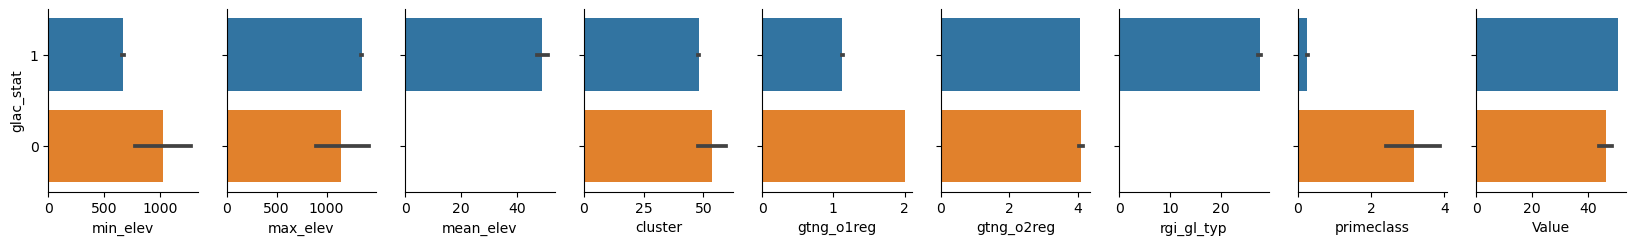

In [29]:
#See influence of variables to target variable
g = sns.PairGrid(clustered_df,
                 x_vars=['min_elev','max_elev','mean_elev','cluster','gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ','primeclass','Value'],
                 y_vars=["glac_stat"],
                 aspect=.75)
#plt.xticks(rotation=90)
g.map(sns.barplot, palette="coolwarm");

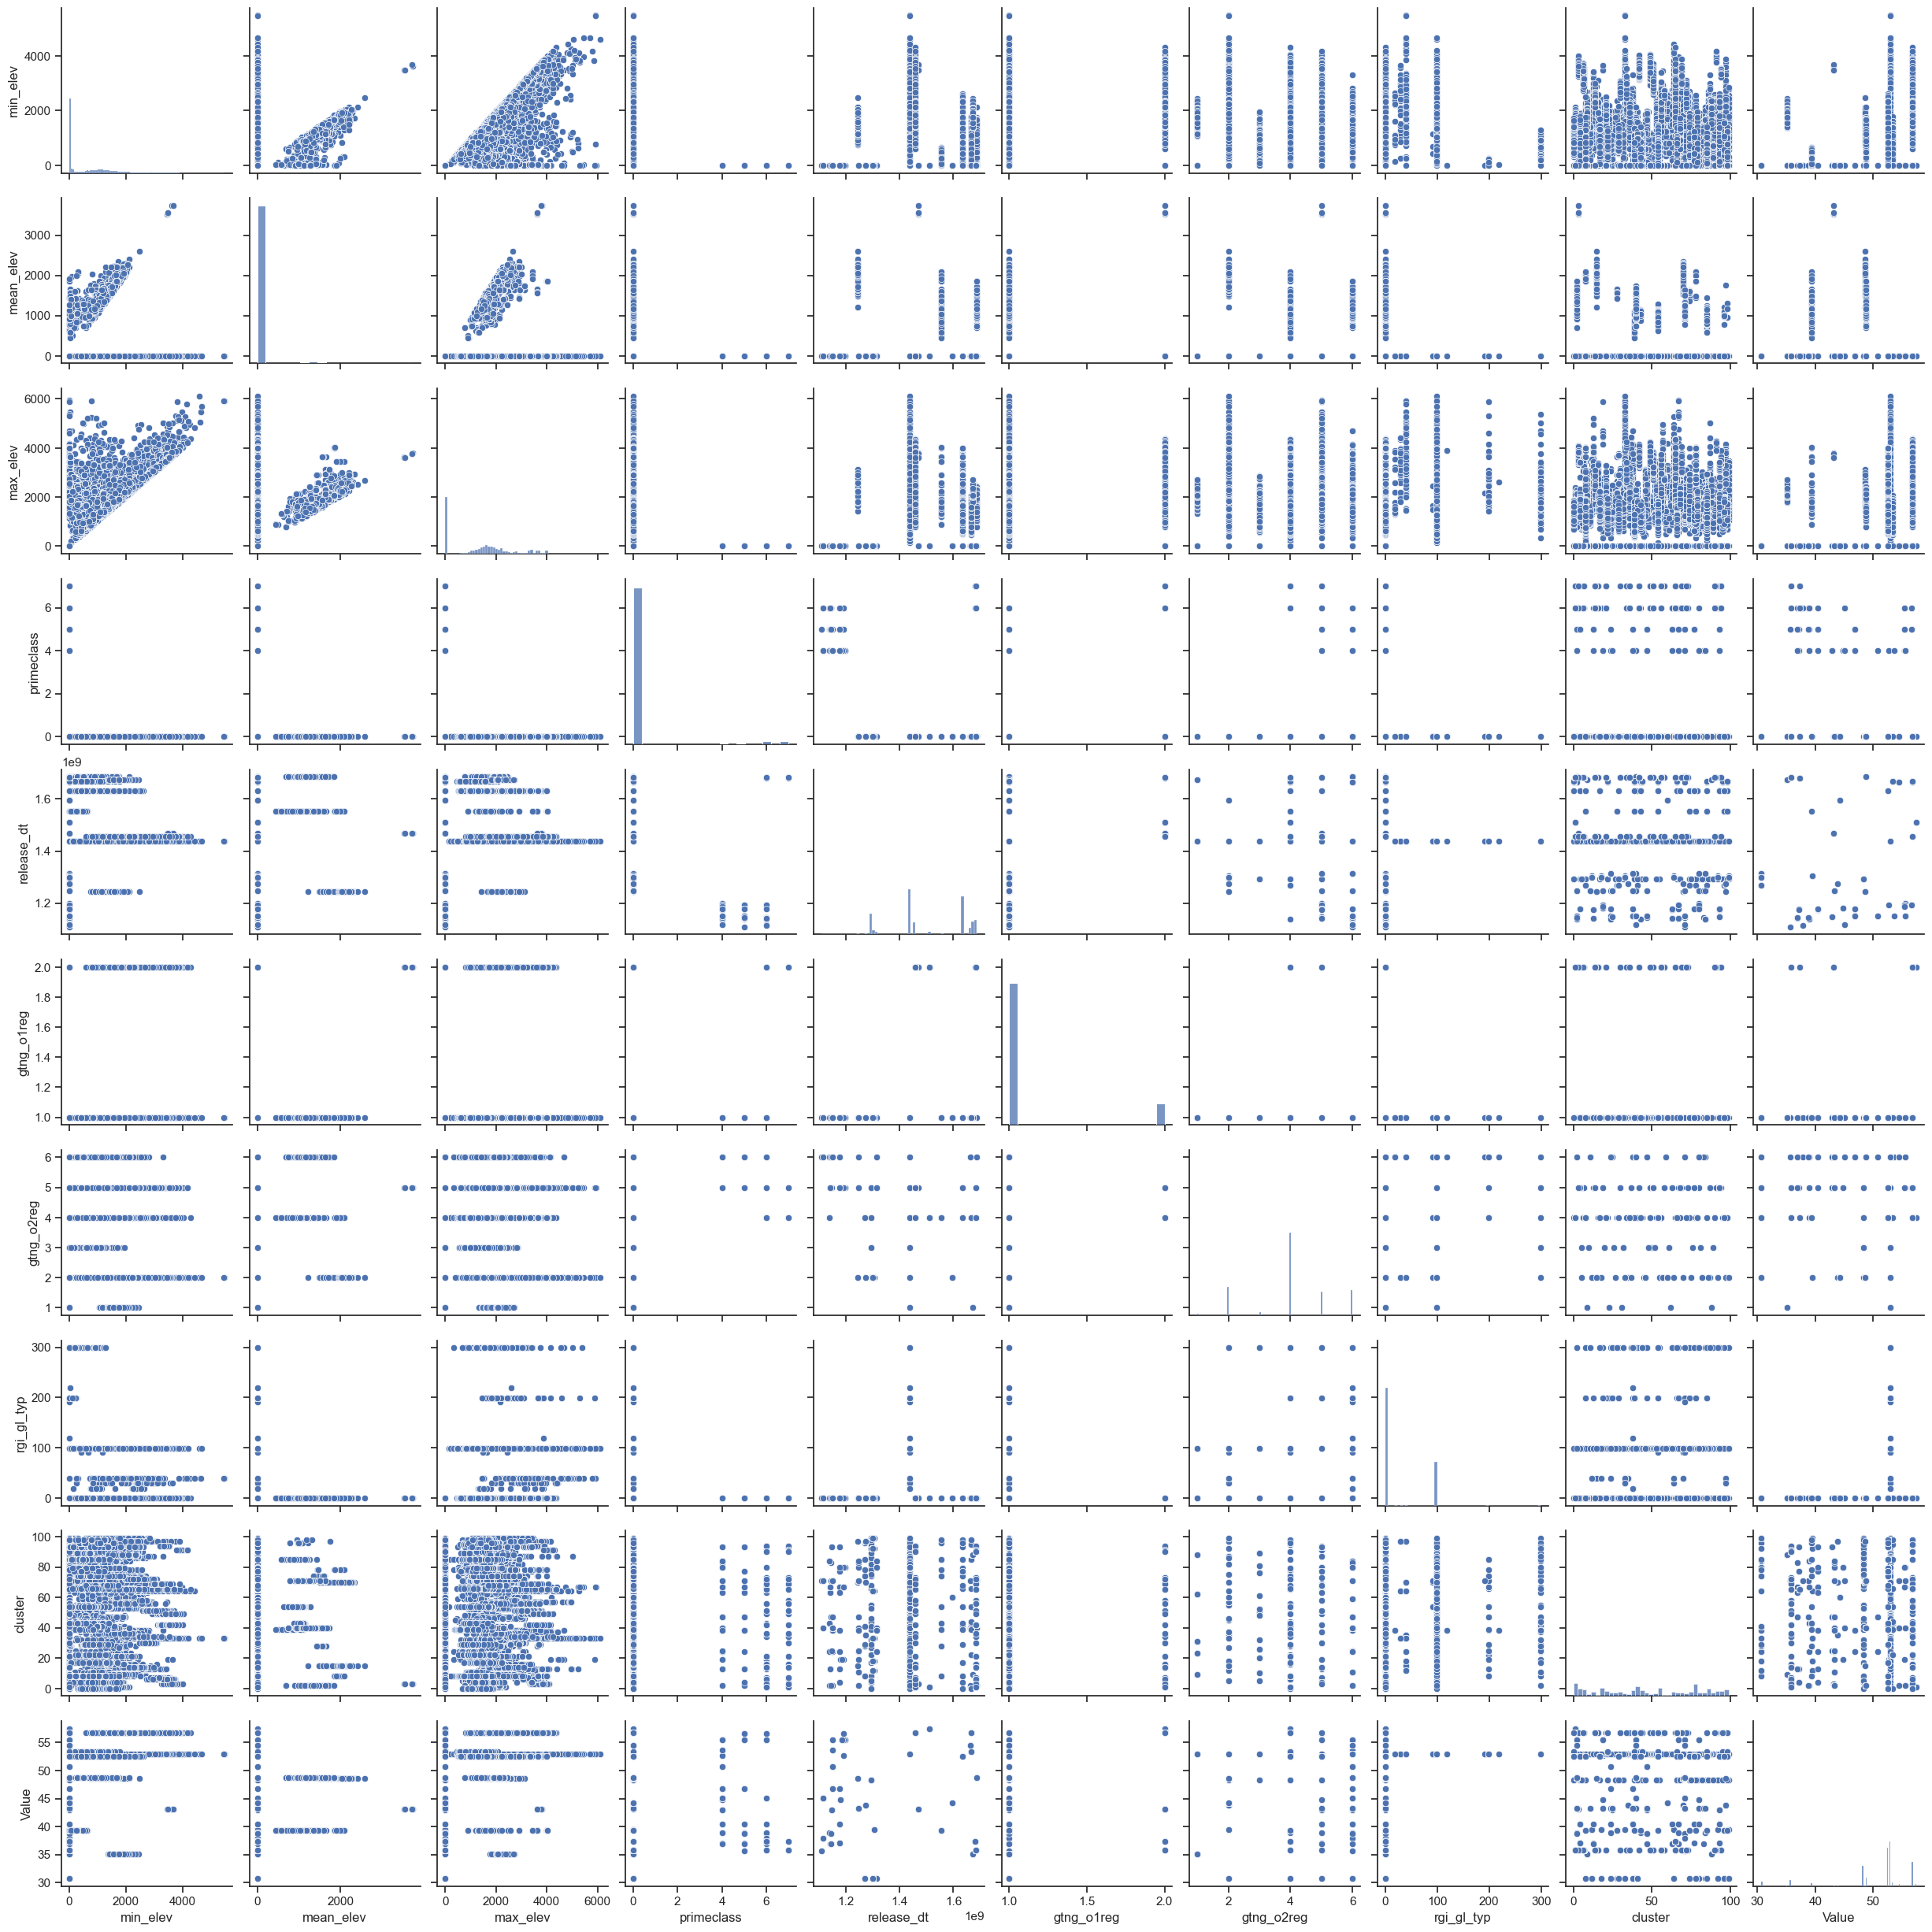

In [30]:
sns.set(style= 'ticks')
cols = ['line_type', 'glac_id', 'anlys_time', 'src_date', 'db_area', 'min_elev',
       'mean_elev', 'max_elev', 'primeclass', 'rec_status', 'release_dt',
       'gone_date', 'glac_name', 'glac_stat', 'geog_area', 'conn_lvl',
       'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg', 'rgi_gl_typ',
       'cluster','Value']
sns.pairplot(clustered_df[cols], height = 2.5)
plt.show();

In [31]:
#Function to plot data
def plotData(x_axis,y_axis):
    data = pd.concat([clustered_df[x_axis], clustered_df[y_axis]], axis=1)
    data.plot.scatter(x=x_axis, y=y_axis)

<Axes: xlabel='min_elev', ylabel='max_elev'>

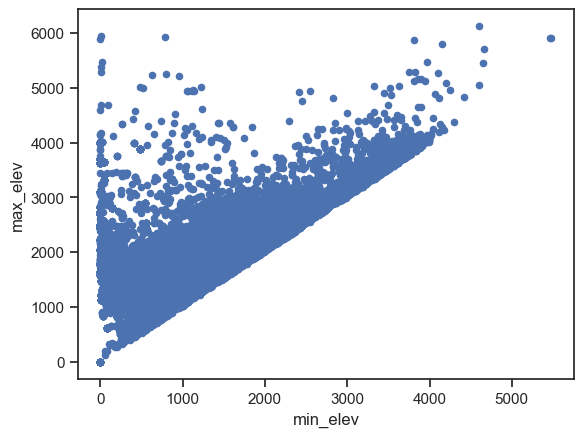

In [32]:
#Zoom in on min_elev/Max_elev
data = pd.concat([clustered_df['min_elev'], clustered_df['max_elev']], axis=1)

data.plot.scatter(x='min_elev', y='max_elev')

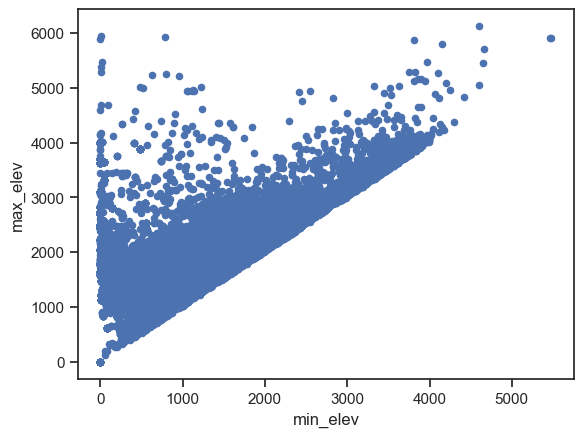

In [33]:
plotData('min_elev','max_elev')

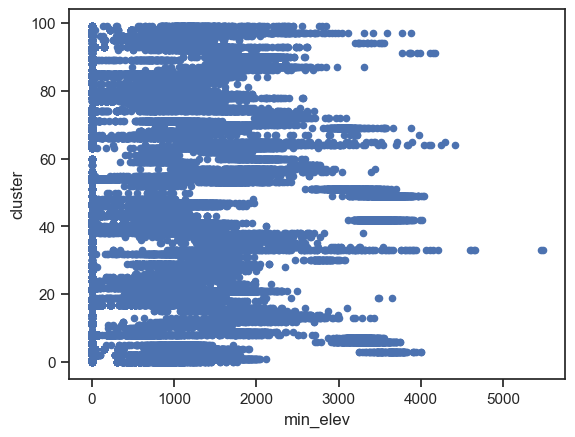

In [34]:
plotData('min_elev','cluster')

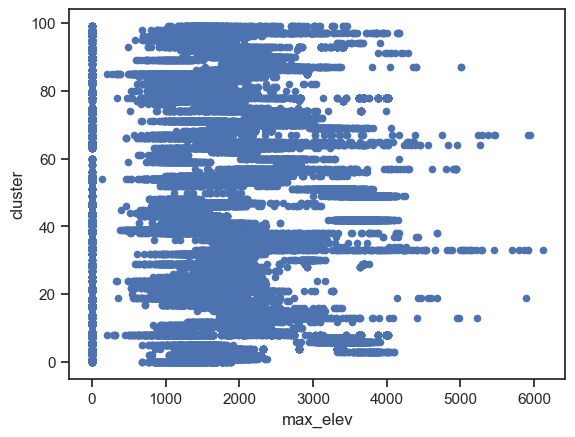

In [35]:
plotData('max_elev','cluster')

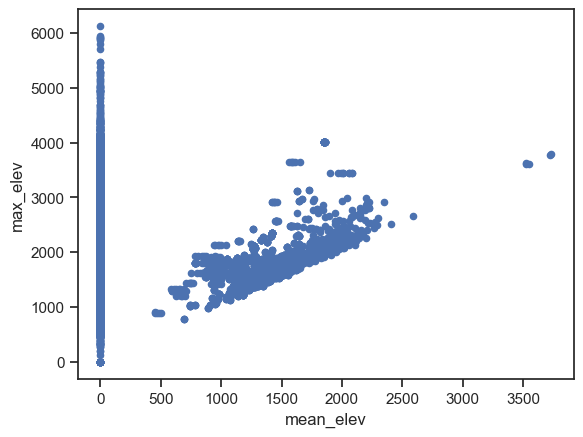

In [36]:
plotData('mean_elev','max_elev')

In [37]:
clustered_df.columns

Index(['line_type', 'glac_id', 'anlys_time', 'src_date', 'db_area', 'min_elev',
       'mean_elev', 'max_elev', 'primeclass', 'rec_status', 'release_dt',
       'gone_date', 'glac_name', 'glac_stat', 'proc_desc', 'geog_area',
       'conn_lvl', 'surge_type', 'term_type', 'gtng_o1reg', 'gtng_o2reg',
       'rgi_gl_typ', 'cluster', 'Value'],
      dtype='object')

In [38]:
#Drop IDS, nameas they are irrelavant
clustered_df = clustered_df.drop(columns='glac_id')
clustered_df = clustered_df.drop(columns='glac_name')
#Drop gone_date, proc_desc, as gone_date can be null, and proc_desc has too many different instances, getting dummies for it will create 30+ extra columns
clustered_df = clustered_df.drop(columns=['gone_date','proc_desc'])

In [39]:
#Convert dates to epochs for to improve relativity between each data
days_since_epoch_anlys = (pd.to_datetime(clustered_df['anlys_time']) - pd.Timestamp(1970, 1, 1))
days_since_epoch_src = (pd.to_datetime(clustered_df['src_date']) - pd.Timestamp(1970, 1, 1))
#days_since_epoch_gone = (pd.to_datetime(clustered_df['gone_date']) - pd.Timestamp(1970, 1, 1))

clustered_df['anlys_time'] = days_since_epoch_anlys.dt.days
clustered_df['src_date'] = days_since_epoch_src.dt.days
#clustered_df['gone_date'] = days_since_epoch_gone.dt.days
clustered_df.head()

,line_type,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,rec_status,release_dt,glac_stat,geog_area,conn_lvl,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,cluster,Value
0,debris_cov,13269,10804,495.176,0,0,0,4,okay,1177210698,1,Various (NSIDC),0,0,9,1,6,0,24,46.77
1,debris_cov,13726,11522,297.56,0,0,0,5,okay,1192067393,1,Various (NSIDC),0,0,9,1,5,0,67,55.43
2,debris_cov,13269,10804,162.882,0,0,0,5,okay,1150232094,1,Various (NSIDC),0,0,9,1,6,0,38,46.77
3,debris_cov,13269,10804,495.176,0,0,0,4,okay,1177210698,1,Various (NSIDC),0,0,9,1,6,0,24,46.77
4,debris_cov,13269,10804,495.176,0,0,0,4,okay,1177210698,1,Various (NSIDC),0,0,9,1,6,0,24,46.77


In [40]:
categorical_df = clustered_df[['line_type','rec_status','geog_area']]

In [41]:
categorical_df.head()

,line_type,rec_status,geog_area
0,debris_cov,okay,Various (NSIDC)
1,debris_cov,okay,Various (NSIDC)
2,debris_cov,okay,Various (NSIDC)
3,debris_cov,okay,Various (NSIDC)
4,debris_cov,okay,Various (NSIDC)


In [42]:
numerical_df = clustered_df.drop(columns=['line_type','rec_status','geog_area','conn_lvl'])

In [43]:
numerical_df['surge_type'].value_counts()

surge_type
0    69119
3      280
2      150
1       23
Name: count, dtype: int64

In [44]:
numerical_df.head()

,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,release_dt,glac_stat,surge_type,term_type,gtng_o1reg,gtng_o2reg,rgi_gl_typ,cluster,Value
0,13269,10804,495.176,0,0,0,4,1177210698,1,0,9,1,6,0,24,46.77
1,13726,11522,297.56,0,0,0,5,1192067393,1,0,9,1,5,0,67,55.43
2,13269,10804,162.882,0,0,0,5,1150232094,1,0,9,1,6,0,38,46.77
3,13269,10804,495.176,0,0,0,4,1177210698,1,0,9,1,6,0,24,46.77
4,13269,10804,495.176,0,0,0,4,1177210698,1,0,9,1,6,0,24,46.77


In [45]:

clustered_df['line_type'].value_counts()

line_type
glac_bound     55560
debris_cov     14009
intrnl_rock        3
Name: count, dtype: int64

In [46]:
#Trying dummies
dummies = pd.get_dummies(categorical_df)
dummies

,line_type_debris_cov,line_type_glac_bound,line_type_intrnl_rock,rec_status_okay,geog_area_Alaska,geog_area_Chugach,geog_area_Conterminous USA,geog_area_Juneau area,geog_area_Kenai Peninsula,geog_area_Northern Cordillera,geog_area_Olympic Peninsula,geog_area_Prince William Sound,geog_area_Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS,geog_area_Various (GlobGlacier),geog_area_Various (NSIDC)
0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
2,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
4,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False
69568,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False
69569,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False
69570,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False


In [47]:
to_train_df = pd.concat([numerical_df,dummies],axis=1)

In [48]:
to_train_df.head()

,anlys_time,src_date,db_area,min_elev,mean_elev,max_elev,primeclass,release_dt,glac_stat,surge_type,...,geog_area_Chugach,geog_area_Conterminous USA,geog_area_Juneau area,geog_area_Kenai Peninsula,geog_area_Northern Cordillera,geog_area_Olympic Peninsula,geog_area_Prince William Sound,geog_area_Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS,geog_area_Various (GlobGlacier),geog_area_Various (NSIDC)
0,13269,10804,495.176,0,0,0,4,1177210698,1,0,...,False,False,False,False,False,False,False,False,False,True
1,13726,11522,297.56,0,0,0,5,1192067393,1,0,...,False,False,False,False,False,False,False,False,False,True
2,13269,10804,162.882,0,0,0,5,1150232094,1,0,...,False,False,False,False,False,False,False,False,False,True
3,13269,10804,495.176,0,0,0,4,1177210698,1,0,...,False,False,False,False,False,False,False,False,False,True
4,13269,10804,495.176,0,0,0,4,1177210698,1,0,...,False,False,False,False,False,False,False,False,False,True


In [49]:
#Assign variables to X and Y for classification 
y = to_train_df['glac_stat']
X = to_train_df.drop(columns='glac_stat')

In [50]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score

In [51]:
#Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9984476513539929

In [52]:
predictions = clf.predict(X_test)

In [53]:
training_matrix = confusion_matrix(y_test,predictions)
training_matrix_df = pd.DataFrame(training_matrix, index = ['Actual Non-Existent Glaciers', 'Actual Existent Glaciers'],
                                columns=['Predicted Non-Existent Glaciers','Predicted Existent Glaciers'])
training_matrix_df

,Predicted Non-Existent Glaciers,Predicted Existent Glaciers
Actual Non-Existent Glaciers,0,18
Actual Existent Glaciers,9,17366


In [54]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       1.00      1.00      1.00     17375

    accuracy                           1.00     17393
   macro avg       0.50      0.50      0.50     17393
weighted avg       1.00      1.00      1.00     17393



In [55]:
r_squared = r2_score(y_test,predictions)

In [56]:
print(r_squared)                                 

-0.5015539568345324


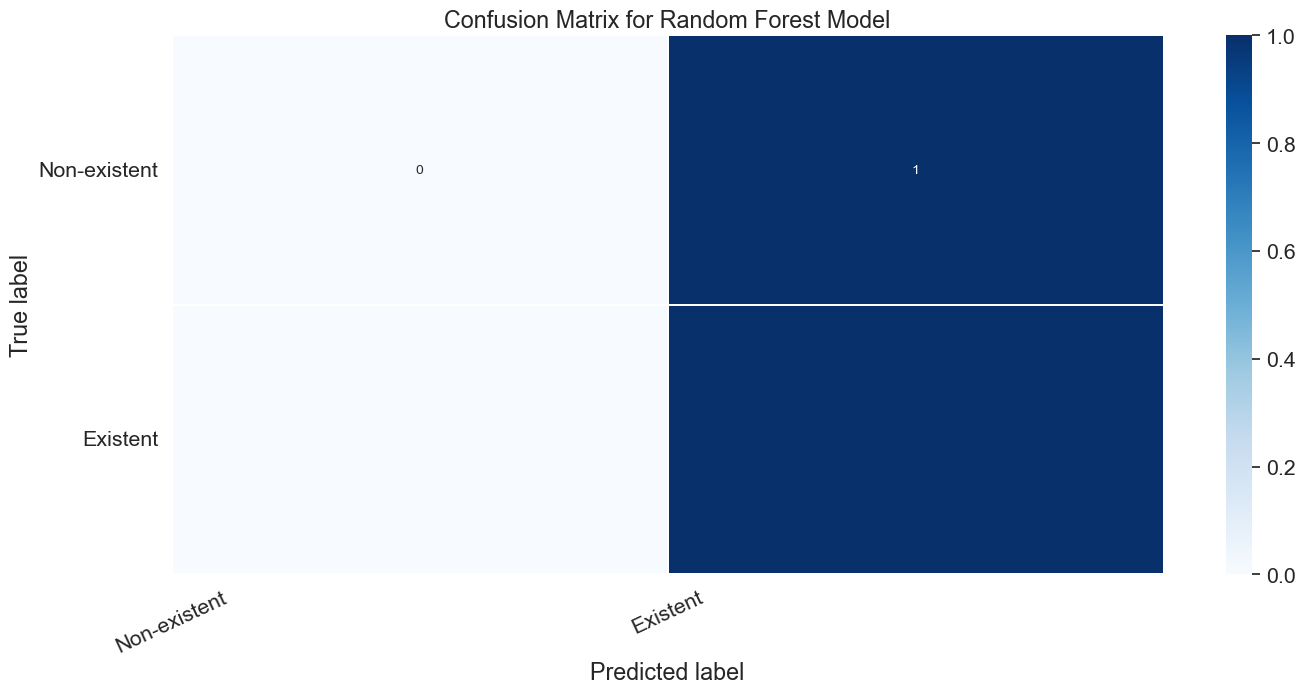

In [57]:
#Trying seaborn display for confusion matrix, not sure if it looks good
# Get and reshape confusion matrix data
training_matrix = training_matrix.astype('float') / training_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(training_matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Non-existent','Existent']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()